# wslfp — Weighted Sum Local Field Potentials

[![DOI](https://zenodo.org/badge/499394073.svg)](https://zenodo.org/doi/10.5281/zenodo.10810169)


This is a lightweight package for computing WSLFP: the weighted sum of synaptic currents LFP proxy from [Mazzoni, Lindén *et al*., 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584). 
WSLFP lets you approximate LFP fairly well from simulations of point neurons in a typical cortical configuration (pyramidal cells and interneurons) without the need for expensive, multi-compartment neuron simulations.
Given the AMPA and GABA synaptic currents onto pyramidal cells, `wslfp` will compute WSLFP for multiple time points and recording locations via a fast, vectorized implementation.
Plus, if you are really impatient and don't even want to [simulate the synaptic currents](#point-neuron-network-simulation), `wslfp` facilitates the [synthesis of said currents from spikes alone](#synthesizing-currents-from-spikes).

The authors argue WSLFP is a good proxy for LFP when:
- There's enough network activity for the LFP to be sizable
- Morphologies are sufficiently "pyramidal," i.e., the centers of GABA and AMPA dendritic bushes are sufficiently separated ($\geq 150$ μm) to generate a dipole moment
- Not recording right at the dipole inversion depth

*This software was developed by [Kyle Johnsen](https://kjohnsen.org), [Olivia Klemmer](https://www.linkedin.com/in/oliviaklemmer), [Chuyu (Alissa) Wang](https://www.linkedin.com/in/chuyu-wang), and [Aarav Shah](https://www.linkedin.com/in/aarav-shah-cs) in the [SIPLab](https://siplab.gatech.edu), led by Chris Rozell and Sankar Alagapan at Georgia Tech.*

*For another point neuron LFP proxy implementation, see [`tklfp`](https://github.com/siplab-gt/tklfp).*

## Installation
Simply install from pypi:
```bash
pip install wslfp
```

## Usage
Keep reading for an end-to-end demo, but here's the gist of it:

```python
import wslfp

# initialize calculator from electrode and current source coordinates
lfp_calc = wslfp.from_xyz_coords(elec_coords, [neuron|population_center]_coords, amp_func=wslfp.mazzoni15)

# get currents from simulation
t_ms = syn_monitor.t / b2.ms
I_ampa = syn_monitor.I_ampa.T
I_gaba = syn_monitor.I_gaba.T
# or from spikes
I_ampa = wslfp.spikes_to_biexp_currents(t_ms, t_spk_exc, i_spk_exc, J, 2, 0.4)
I_gaba = wslfp.spikes_to_biexp_currents(t_ms, t_spk_inh, i_spk_inh, J, 5, 0.25)

# calculate LFP
lfp = lfp_calc.calculate(
    t_eval_ms=t_ms,
    t_ampa_ms=t_ms,
    I_ampa=I_ampa,
    t_gaba_ms=t_ms,
    I_gaba=I_gaba,
)
```



### Point neuron network simulation

First we need a point neuron simulation to approximate the LFP for.
Here we adapt a balanced E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network).
Note that we record synaptic currents only from pyramidal cells, since contributions from interneurons are insignificant.
For simplicity, we are ignoring currents produced by the external input; for maximum realism you would want to account for all postsynaptic currents.

<details>
<summary>🔍 Click to see Brian simulation code</summary>



In [1]:
import brian2.only as b2
import matplotlib.pyplot as plt
import numpy as np

b2.prefs.codegen.target = "numpy"
b2.seed(18470724)
rng = np.random.default_rng(18470724)

In [2]:
N_excit = 800
N_inhib = None  # None = N_excit / 4
N_extern = 1000
connection_probability = 0.1
# w0 = 0.1 * b2.mV
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1.5 * b2.ms
# poisson_input_rate = 13 * b2.Hz
poisson_input_rate = 9 * b2.Hz
# w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
random_vm_init = True

if N_inhib is None:
    N_inhib = int(N_excit / 4)
N_tot = N_excit + N_inhib
if N_extern is None:
    N_extern = int(N_excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_ampa + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_ampa : amp
    I_gaba : amp
"""

neurons = b2.NeuronGroup(
    N_tot,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_excit + N_inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest

excitatory_population = neurons[:N_excit]
inhibitory_population = neurons[N_excit:]

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp (clock-driven)
    I_TYPE_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp (clock-driven)
"""

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    model=syn_eqs.replace("TYPE", "ampa"),
    on_pre="s += J_excit",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    model=syn_eqs.replace("TYPE", "gaba"),
    on_pre="s += J_inhib",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.25 * b2.ms, "tau_dsyn": 5 * b2.ms},
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

spike_monitor = b2.SpikeMonitor(neurons, record=True)
current_monitor = b2.StateMonitor(neurons, ["I_ampa", "I_gaba"], record=range(N_excit))

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    spike_monitor,
    current_monitor,
)

net.run(0.5 * b2.second)

INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.32s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.16s). [brian2.stateupdaters.base.method_choice]


</details>

Now let's plot the resulting spike raster:

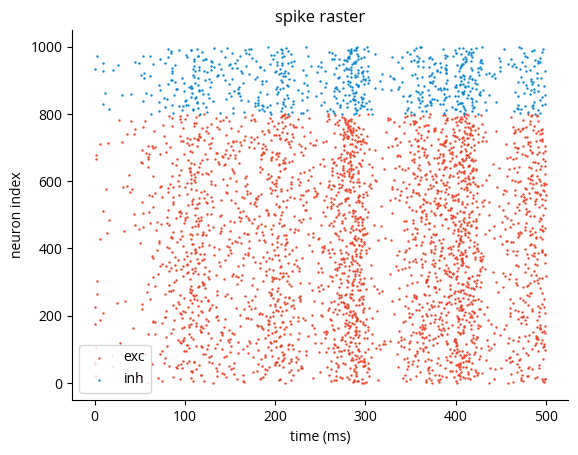

In [3]:
fig, ax1 = plt.subplots()
c_exc = "xkcd:tomato"
c_inh = "xkcd:cerulean"
t_spk_exc = spike_monitor.t[spike_monitor.i < N_excit] / b2.ms
i_spk_exc = spike_monitor.i[spike_monitor.i < N_excit]
t_spk_inh = spike_monitor.t[spike_monitor.i >= N_excit] / b2.ms
i_spk_inh = spike_monitor.i[spike_monitor.i >= N_excit]
ax1.scatter(t_spk_exc, i_spk_exc, s=0.5, c=c_exc, label="exc")
ax1.scatter(t_spk_inh, i_spk_inh, s=0.5, c=c_inh, label="inh")
ax1.legend()
ax1.set(xlabel="time (ms)", ylabel="neuron index", title="spike raster");

### Neuron and electrode coordinates
Let's give our neurons coordinates in space and choose recording sites.
Again, since only synaptic currents onto pyramidal cells contribute significantly to LFP, we'll ignore interneurons.

In [4]:
exc_coords = rng.uniform(-250, 250, (N_excit, 3))
exc_coords[:5]

array([[ 104.6606786 ,  205.54732892, -148.12166896],
       [ -43.94925826,  -10.14448589,  241.31175062],
       [-210.4378934 ,   93.42302493,  148.58298887],
       [ 206.65832644,   24.76391578,  213.96022925],
       [  66.21804613,   77.7437387 ,   32.07423479]])

In [5]:
rec_radii = np.array([0, 250, 500])
elec_coords = np.meshgrid(rec_radii, [0], np.linspace(-400, 600, 10))
elec_coords = np.column_stack([a.flatten() for a in elec_coords])
elec_coords[0:10]

array([[   0.        ,    0.        , -400.        ],
       [   0.        ,    0.        , -288.88888889],
       [   0.        ,    0.        , -177.77777778],
       [   0.        ,    0.        ,  -66.66666667],
       [   0.        ,    0.        ,   44.44444444],
       [   0.        ,    0.        ,  155.55555556],
       [   0.        ,    0.        ,  266.66666667],
       [   0.        ,    0.        ,  377.77777778],
       [   0.        ,    0.        ,  488.88888889],
       [   0.        ,    0.        ,  600.        ]])

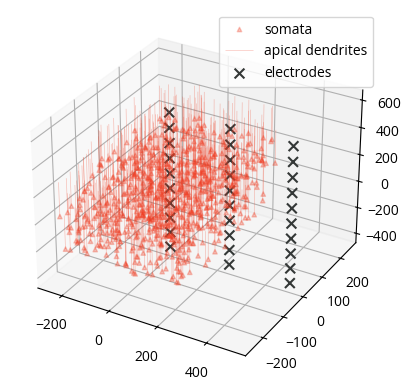

In [6]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

fig = plt.figure()
ax1 = fig.add_subplot(projection="3d")
apex_coords = exc_coords + [0, 0, 250]
ax1.scatter(*exc_coords.T, marker="^", color=c_exc, label="somata", alpha=0.3, s=10)
apical_dendrites = np.stack([exc_coords, apex_coords], axis=1)
assert apical_dendrites.shape == (N_excit, 2, 3)

# The most efficient way to plot multiple lines at once:
lines = Line3DCollection(
    apical_dendrites, color=c_exc, alpha=0.3, label="apical dendrites", linewidth=0.5
)
ax1.add_collection(lines)

ax1.scatter(
    *elec_coords.T, marker="x", alpha=1, s=50, color="xkcd:charcoal", label="electrodes"
)
ax1.legend()

### Calculator initialization

Now we initialize a `WSLFPCalculator` object which stores parameter settings and the contributions from each source to the total LFP, facilitating repeated calls for real-time use.
We can either follow Mazzoni, Lindén *et al.*'s original approach of aggregating currents over the whole population, or treat each neuron as a separate current source.
The `WSLFPCalculator` computes relative coordinates between electrodes and current sources and stores the amplitude contribution of each source to the total signal.

Different amplitude profiles are available and can be specified via the `amp_func` parameter:
- `mazzoni15_pop`: derived from [Fig. 2B of the original paper](https://doi.org/10.1371/journal.pcbi.1004584.g002).
    The most accurate option since it was based on detailed simulations.
    It is most appropriate when each source represents a population of neurons since that is how the data was produced.
- `mazzoni15_nrn`: has the same shape as `mazzoni15`, but is optimally shrunk and scaled so that the profile of individual neurons averaged out over a 250 μm-radius cylinder is as close as possible to the population profile.
- `aussel18`: uses the closed-form equation for contributions from individual neurons described in [Aussel *et al.*, 2018](https://doi.org/10.1007/s10827-018-0704-x): $U = \frac{Lcos\theta}{4\pi\sigma r^2} (I_{syn_E} + I_{syn_I})$

These amplitudes are averaged (rather than summed) across neurons or populations so that the scale of the resulting signal matches the paper (between about -0.1 and 0.1 μV for close recordings), regardless of how many neurons or populations are present.
For a detailed comparison, see [`amplitude_comparison.ipynb`](notebooks/amplitude_comparison.ipynb).

Electrode and pyramidal cell (or population center) coordinates are $N \times 3$ arrays and are given in μm.
By default, it is assumed the current source coordinates represent the pyramidal cell somata, though the dipole center can be specified instead by setting `source_coords_are_somata` to `False`.

In the case your current sources (pyramidal cells or populations) aren't uniformly pointing "up," you can pass a 3D vector of $N \times 3$ array via the `source_orientation` parameter.
The default is `[0, 0, 1]`, indicating that the positive z axis is "up," towards the cortical surface.

The calculator also stores parameters $\alpha, \tau_\text{GABA}, \tau_\text{AMPA}$.
The defaults follow the Reference WSLFP (RWSLFP) values from the paper, the difference from WSLFP being that $\alpha$ is constant across depths.

In [7]:
import wslfp

lfp_calc = wslfp.from_xyz_coords(elec_coords, exc_coords, amp_func=wslfp.mazzoni15_nrn)
lfp_calc_pop = wslfp.from_xyz_coords(
    elec_coords, exc_coords.mean(axis=0), amp_func=wslfp.mazzoni15_pop
)

### Computing from currents

We then compute the LFP signal from the synaptic currents we recorded during the simulation.
For demonstration purposes, we use again use both the population and per-neuron versions:

In [8]:
t_ms = current_monitor.t / b2.ms
lfp = lfp_calc.calculate(
    t_ms, t_ms, current_monitor.I_ampa.T, t_ms, current_monitor.I_gaba.T
)

WARNING    /home/kyle/Dropbox (GaTech)/projects/wslfp/wslfp/__init__.py:85: UserWarning: Insufficient current data to interpolate for the requested times. Assuming 0 current for out-of-range times. Needed [-6.0, 493.9] ms, provided [0.0, 499.9] ms.
  warnings.warn(
 [py.warnings]


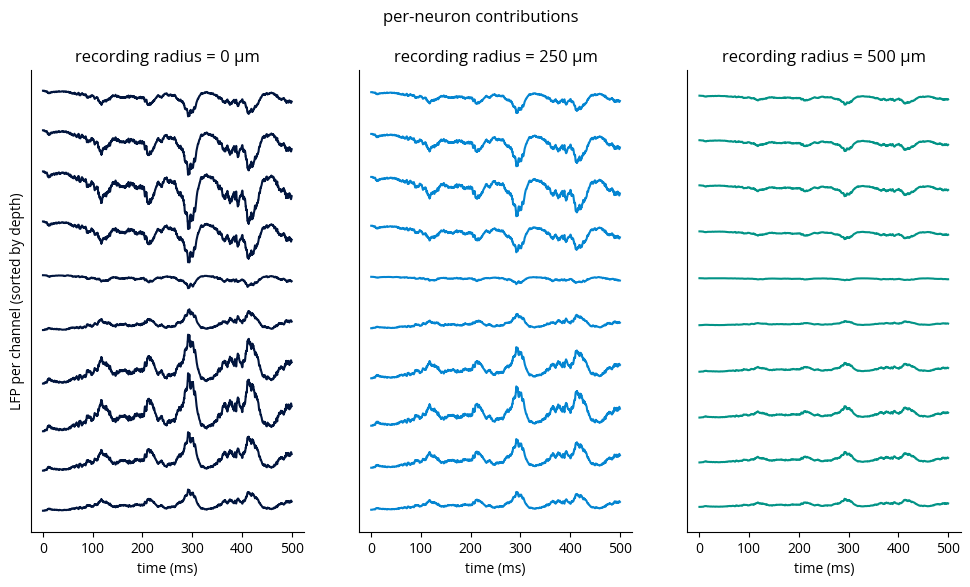

In [9]:
def plot_lfp(lfp, title=None):
    n_shanks = 3
    n_contacts_per_shank = 10
    fig, axs = plt.subplots(1, n_shanks, sharey=True, figsize=(12, 6))
    for i, color, r_rec, ax in zip(
        range(n_shanks), ["xkcd:navy", "xkcd:cerulean", "xkcd:teal"], rec_radii, axs
    ):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * 1.1 * np.abs(lfp.max()),
            c=color,
        )
        ax.set(xlabel="time (ms)", yticks=[], title=f"recording radius = {r_rec} µm")

    axs[0].set(ylabel="LFP per channel (sorted by depth)")
    if title:
        fig.suptitle(title)


plot_lfp(lfp, "per-neuron contributions")

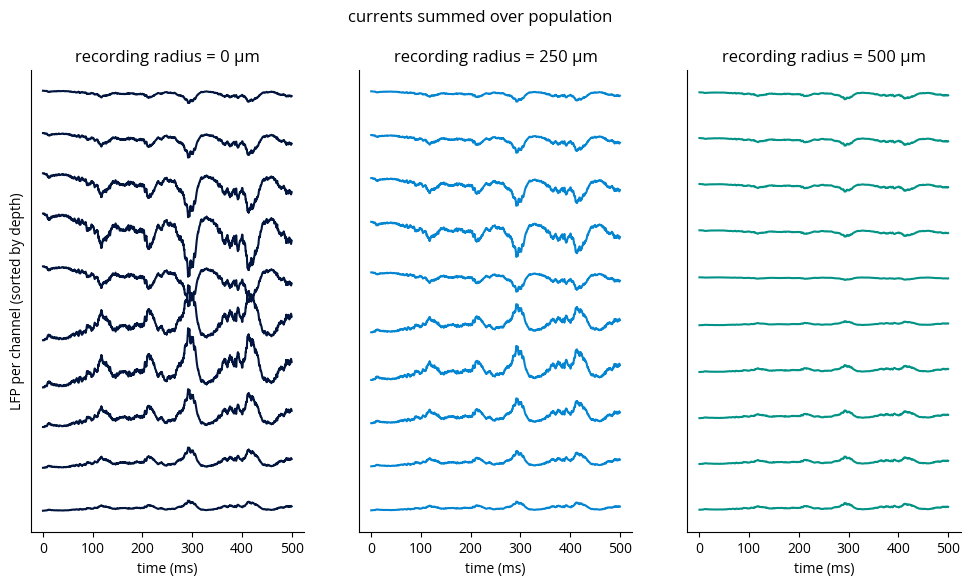

In [10]:
lfp_pop = lfp_calc_pop.calculate(
    t_ms,
    t_ms,
    current_monitor.I_ampa.sum(axis=0),
    t_ms,
    current_monitor.I_gaba.sum(axis=0),
)
plot_lfp(lfp_pop, title="currents summed over population")

### Synthesizing currents from spikes
`wslfp` provides functions to generate synaptic currents from spikes to avoid having to simulate synaptic dynamics.
We do this by [convolving spikes with a biexponential curve](notebooks/postsynaptic_currents.ipynb) at each postsynaptic target.
The computation requires spike times and source indices, as well as a connectivity/weight matrix to determine where and how much current to deliver for each spike. 

In [11]:
# connection matrices can be big; use a sparse matrix to save memory
from scipy import sparse

J = sparse.lil_array((N_tot, N_tot))
J[exc_synapses.i, exc_synapses.j] = J_excit
# careful with indexing: subgroup indexing (and thus synapse.i) starts over
# again with 0, despite coming from subgroup starting at index N_excit
J[inhib_synapses.i + N_excit, inhib_synapses.j] = J_inhib
J = J.tocsr()[:, :N_excit]  # only need spikes onto pyramidal cells

I_ampa = wslfp.spikes_to_biexp_currents(
    t_ms, t_spk_exc, i_spk_exc, J, 2, 0.4, syn_delay_ms=synaptic_delay / b2.ms
)
I_gaba = wslfp.spikes_to_biexp_currents(
    t_ms, t_spk_inh, i_spk_inh, J, 5, 0.25, syn_delay_ms=synaptic_delay / b2.ms
)
lfp_spike = lfp_calc.calculate(t_ms, t_ms, I_ampa, t_ms, I_gaba)

WARNING    /home/kyle/Dropbox (GaTech)/projects/wslfp/wslfp/__init__.py:85: UserWarning: Insufficient current data to interpolate for the requested times. Assuming 0 current for out-of-range times. Needed [-6.0, 493.9] ms, provided [0.0, 499.9] ms.
  warnings.warn(
 [py.warnings]


We don't expect the two results to be exactly equal [because of the inexactness of numerical integration](notebooks/postsynaptic_currents.ipynb#biexponential-synaptic-currents).


In [12]:
np.allclose(lfp_spike, lfp)

False

In [13]:
lfp_spike_pop = lfp_calc_pop.calculate(
    t_ms, t_ms, I_ampa.sum(axis=1), t_ms, I_gaba.sum(axis=1)
)
np.allclose(lfp_spike_pop, lfp_pop)

False

This slight difference carries through to the LFP signal as well.
In this case, where we actually did simulate the currents and can compare the two approaches, it's hard to say which is more *correct*.
The convolution is exact, unlike the simulation's ODE integration, but the inexact simulated currents are the "ground truth" in terms of driving network activity.

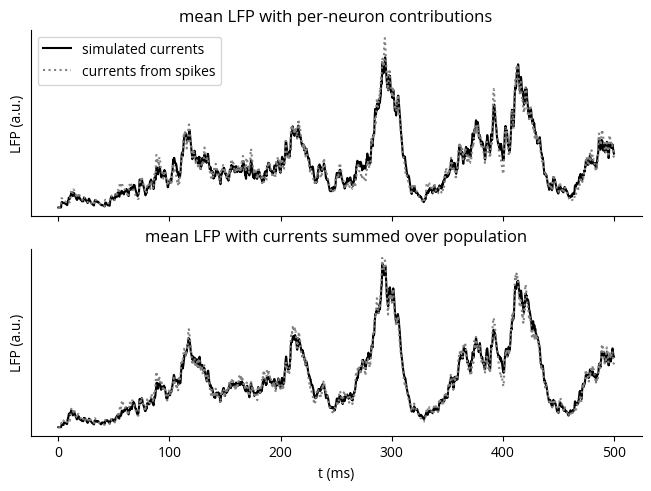

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout="constrained")
ax1.plot(t_ms, lfp.mean(axis=1), label="simulated currents", c="k")
ax1.plot(
    t_ms, lfp_spike.mean(axis=1), label="currents from spikes", linestyle=":", c="gray"
)
ax1.set(title="mean LFP with per-neuron contributions", yticks=[], ylabel="LFP (a.u.)")
ax1.legend()
ax2.plot(t_ms, lfp_pop.mean(axis=1), label="simulated currents", c="k")
ax2.plot(
    t_ms,
    lfp_spike_pop.mean(axis=1),
    label="currents from spikes",
    linestyle=":",
    c="gray",
)
ax2.set(
    title="mean LFP with currents summed over population",
    xlabel="t (ms)",
    yticks=[],
    ylabel="LFP (a.u.)",
);

The spectral properties are also very similar, the main difference apparently being that the convolution method has slightly higher power overall.

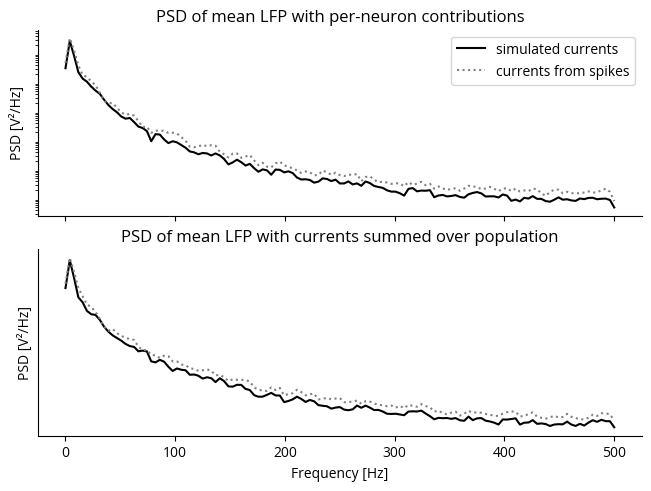

In [15]:
from scipy.signal import welch

fs = 1000
fig, axs = plt.subplots(2, 1, layout="constrained", sharex=True)

axs[0].semilogy(*welch(lfp.mean(axis=1), fs=fs), c="k", label="simulated currents")
axs[0].semilogy(
    *welch(lfp_spike.mean(axis=1), fs=fs),
    c="gray",
    linestyle=":",
    label="currents from spikes",
)
axs[0].set(
    ylabel="PSD [V²/Hz]",
    title="PSD of mean LFP with per-neuron contributions",
    yticks=[],
)
axs[0].legend()

axs[1].semilogy(*welch(lfp_pop.mean(axis=1), fs=fs), c="k", label="simulated currents")
axs[1].semilogy(
    *welch(lfp_spike_pop.mean(axis=1), fs=fs),
    c="gray",
    linestyle=":",
    label="currents from spikes",
)
axs[1].set(
    ylabel="PSD [V²/Hz]",
    xlabel="Frequency [Hz]",
    title="PSD of mean LFP with currents summed over population",
    yticks=[],
);

## Future development
These features might be useful to add in the future:
- amplitude and $\alpha$ that vary by axon length as well as by recording position